In [2]:
import os
import numpy as np
np.random.seed(1234)
import scipy.io
# from pyDOE import lhs
import json
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors

sys.path.append('../../utils')
from second_model import second_model
from bc import BC_u

In [3]:
def BC_struct(Z,Y,U_r,U_i,nz,ny,BCz,BCy):
    net_z = len(BCz)-1
    net_y = len(BCy)-1
    Z_t = np.ones((net_y*ny,2))
    Z_b = np.ones((net_y*ny,2))
    Z_l = np.ones((net_z*nz,2))
    Z_r = np.ones((net_z*nz,2))
    for jj in range(net_z):   # left and right    
        z0 = np.linspace(Z[BCz[jj],0],Z[BCz[jj+1]-1,0],nz)
        y0 = np.linspace(Y[BCz[jj],0],Y[BCz[jj+1]-1,0],nz)
        Z_l[jj*nz:(jj+1)*nz,:] = np.hstack((y0.flatten()[:,None],z0.flatten()[:,None]))
        z0 = np.linspace(Z[BCz[jj],-1],Z[BCz[jj+1]-1,-1],nz)
        y0 = np.linspace(Y[BCz[jj],-1],Y[BCz[jj+1]-1,-1],nz)
        Z_r[jj*nz:(jj+1)*nz,:] = np.hstack((y0.flatten()[:,None],z0.flatten()[:,None]))
#     u_r= u0.flatten()[:,None]
    for jj in range(net_y): # top and bottom
        z0 = np.linspace(Z[0,BCy[jj]],Z[0,BCy[jj+1]-1],ny)
        y0 = np.linspace(Y[0,BCy[jj]],Y[0,BCy[jj+1]-1],ny)
        Z_t[jj*ny:(jj+1)*ny,:] = np.hstack((y0.flatten()[:,None],z0.flatten()[:,None]))
        z0 = np.linspace(Z[-1,BCy[jj]],Z[-1,BCy[jj+1]-1],ny)
        y0 = np.linspace(Y[-1,BCy[jj]],Y[-1,BCy[jj+1]-1],ny)
        Z_b[jj*ny:(jj+1)*ny,:] = np.hstack((y0.flatten()[:,None],z0.flatten()[:,None]))
    u_l = np.zeros_like(Z_l,dtype=complex)[:,0:1]
    u_r = np.zeros_like(Z_r,dtype=complex)[:,0:1]
    u_t = np.zeros_like(Z_t,dtype=complex)[:,0:1]
    u_b = np.zeros_like(Z_b,dtype=complex)[:,0:1]
    Z_dict = {
        "Z_t": Z_t,
        "Z_b": Z_b,
        "Z_l": Z_l,
        "Z_r": Z_r,
        "u_t": u_t,
        "u_b": u_b,
        "u_r": u_r,
        "u_l": u_l
    }
    return Z_dict

In [4]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.pad_inches"] = 0.1

In [20]:
data_FEM = scipy.io.loadmat("../../Data/CM2D2_FEM.mat")
obs_FEM = data_FEM["obs"].flatten()/1e3
rho_FEM_TE= data_FEM["rho_TE"].flatten()
phs_FEM_TE= data_FEM["phs_TE"].flatten()
# rho_FEM_TM= data_FEM["rho_TM"].flatten()
# phs_FEM_TM= data_FEM["phs_TM"].flatten()


H_c = np.loadtxt("../../Data/CM2D2_10s.dat")
obs_c = H_c[:,0]
rho_TE = H_c[:,1]
rho_TE_er = H_c[:,2]
# rho_TM = H_c[:,3]
# rho_TM_er = H_c[:,4]

In [6]:
freq = 1.0/10
ny = 100
nz = 100
y_0 = np.array([-2e5,-22e3,-4e3,10e3,22e3,2e5])
z_0 = np.array([-2e5,0,7e3,9e3,75e3,2e5])
y1 = np.linspace(y_0[0],y_0[1],ny+1)[:-1]
y2 = np.linspace(y_0[1],y_0[2],ny+1)[:-1]
y3 = np.linspace(y_0[2],y_0[3],ny+1)[:-1]
y4 = np.linspace(y_0[3],y_0[4],ny+1)[:-1]
y5 = np.linspace(y_0[4],y_0[5],ny)
z1 = np.linspace(z_0[0],z_0[1],nz+1)[:-1]
z2 = np.linspace(z_0[1],z_0[2],nz+1)[:-1]
z3 = np.linspace(z_0[2],z_0[3],nz+1)[:-1]
z4 = np.linspace(z_0[3],z_0[4],nz+1)[:-1]
z5 = np.linspace(z_0[4],z_0[5],nz)
y  = np.concatenate((y1,y2,y3,y4,y5))
z  = np.concatenate((z1,z2,z3,z4,z5))
Y,Z= np.meshgrid(y,z)

In [7]:
BCz = np.array([0,nz,2*nz,3*nz,4*nz,5*nz])
BCy = np.array([0,len(y)])
sigma0 = np.array([1e-9,1e-2,1e-2,1e-2,1e-1])
Sigma0 = np.ones_like(Y)
for jj in range(len(BCz)-1):
    Sigma0[BCz[jj]:BCz[jj+1],:]=sigma0[jj]
mu_0 = 4*np.pi*1e-7 
omega = 2*np.pi*freq
Beta0 = np.sqrt(mu_0*Sigma0*omega)

sigL = sigma0[:]
hL   = z_0[1:]
hL[-1] = 1e20
sigR = sigL
hR   = hL

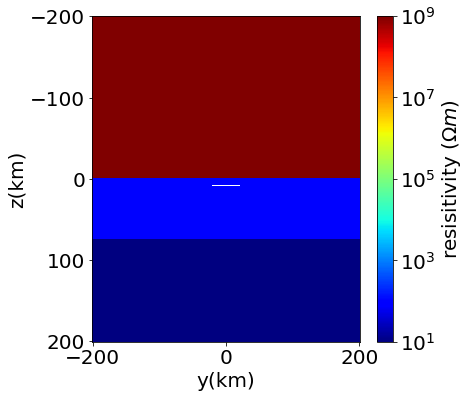

In [8]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1)
h = ax.pcolormesh(Y/1e3,Z/1e3, 1/Sigma0, norm=colors.LogNorm(vmin=1/Sigma0.min(), vmax=1/Sigma0.max()),
                  cmap='jet',shading='auto')
ax.invert_yaxis()
ax.set_xlabel("y(km)")
ax.set_ylabel("z(km)")
cbar = fig.colorbar(h)
cbar.ax.set_ylabel(r'resisitivity ($\Omega m$)', rotation=90)
# plt.savefig("./imag/CM2D0_media.jpg", dpi=300,bbox_inches='tight',pad_inches=0.0)

plt.show()

In [9]:
U_real = np.ones_like(Y)
U_real[-1,:] = 0.0
U_imag = np.zeros_like(Y)
U = (U_real,U_imag)

ep = np.concatenate((sigL.flatten()[:,None],hL.flatten()[:,None]),1)
E0_model = BC_u(ep,freq,"TE")

In [10]:
hp={}
hp["cuda"] = False
hp["cluster"] = False
hp["Rm1"] = -1.0
hp["Rm2"] = 1.0

hp["net_type"] = "complex"
hp["layers"] = [2, 400,1]
hp["N_y"] = 40#hp["layers"][-2]
hp["N_z"] = 40#hp["layers"][-2]
hp["N_yi"] = 40#hp["N_y"] # number of points on the interface.
hp["N_zi"] = 40#hp["N_z"]
hp["N_inter"] = 0

hp["L2"] = 0
# Tanh
hp["activation"] = ["Tanh"]*1
# default,uniform, norml, xavier_normal, xavier_uniform,
hp["init"] = "uniform"
hp["freq"] = freq

cond = None # 1e-7

In [11]:
BCz = np.array([0,nz,2*nz,3*nz,4*nz,5*nz])
BCy = np.array([0,ny,2*ny,3*ny,4*ny,5*ny])
sigma_ = np.array([[0,0,0,0,0],
                   [0,0,0,0,0],
                   [0,9.99,0,9.99,0],
                   [0,0,0,0,0],
                   [0,0,0,0,0]])
Sigma_ = np.ones_like(Y)
for ii in range(len(BCy)-1):
    for jj in range(len(BCz)-1):
        Sigma_[BCz[jj]:BCz[jj+1],BCy[ii]:BCy[ii+1]]=sigma_[jj,ii]
mu_0 = 4*np.pi*1e-7    
omega = 2*np.pi*freq
Beta_ = np.sqrt(mu_0*Sigma_*omega)

# sigL = sigma[1:,0]
# hL   = np.array([5e4])
# sigR = sigma[1:,-1]
# hR   = np.array([5e4])

In [12]:
Sigma = Sigma0 + Sigma_

BCy = np.array([0,int(0.6*ny),int(0.8*ny),ny,2*ny,3*ny,4*ny,int(4.2*ny),int(4.4*ny),5*ny])
BCz = np.array([0,int(0.4*nz),nz,2*nz,3*nz,4*nz,5*nz])

Z_u = BC_struct(Z,Y,U_real,U_imag,hp["N_zi"],hp["N_yi"],BCz,BCy)
BCy[-1] = 5*ny-1
BCz[-1] = 5*nz-1

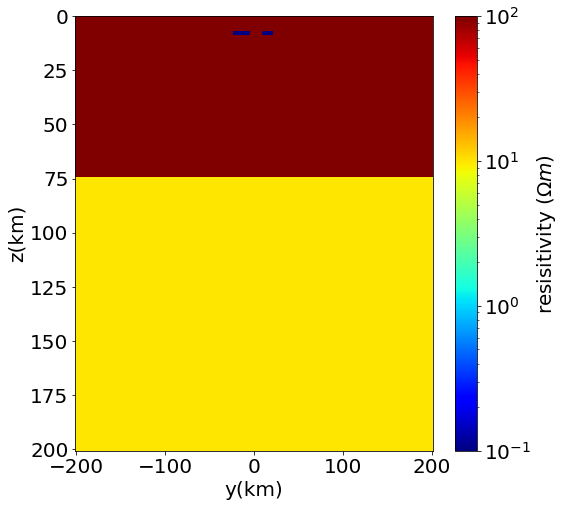

In [13]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)
h = ax.pcolormesh(Y[BCz[2]:,:]/1e3,Z[BCz[2]:,:]/1e3, 1/Sigma[BCz[2]:,:], \
                  norm=colors.LogNorm(vmin=1/Sigma[BCz[2]:,:].min(), vmax=1/Sigma[BCz[2]:,:].max()),
                  cmap='jet',shading='auto')
# line_z = np.linspace(y.min()/1e3, y.max()/1e3, 2)[:,None]
# for ii in range(1,len(BCz)-1):
#     ax.plot(line_z, z[BCz[ii]]*np.ones((2,1))/1e3, 'w--', linewidth = 2)
# line_y = np.linspace(z.min()/1e3, z.max()/1e3, 2)[:,None]
# for ii in range(1,len(BCy)-1):
#     ax.plot(y[BCy[ii]]*np.ones((2,1))/1e3, line_y, 'w--', linewidth = 2)
ax.invert_yaxis()
ax.set_xlabel("y(km)")
ax.set_ylabel("z(km)")
cbar = fig.colorbar(h)
cbar.ax.set_ylabel(r'resisitivity ($\Omega m$)', rotation=90)
# plt.savefig("./imag/CM2D0_media.jpg", dpi=300,bbox_inches='tight',pad_inches=0.0)

plt.show()

In [14]:
cond = None

omega = 2*np.pi*freq
Beta_ = np.sqrt(mu_0*Sigma_*omega)
Beta = np.sqrt(mu_0*Sigma*omega)

pinn2 = second_model(hp, Z_u,Y,Z,Beta,Beta_,U, E0_model,BCy,BCz)
# 'gelsd', 'gelsy', 'gelss'
pinn2.train(cond,'gelsd',"gaussian","none")

all time: 12:52


In [15]:
u_pred_ = pinn2.predict_cpu(Y,Z,BCy,BCz)
E,_ = E0_model.compute_E_H(np.concatenate((Y.flatten()[:,None],Z.flatten()[:,None]),1))
u_pred0 = E[:,0:1].reshape(np.shape(Y))
u_pred = u_pred0+u_pred_

FileNotFoundError: [Errno 2] No such file or directory: './imag/TE_secondary.png'

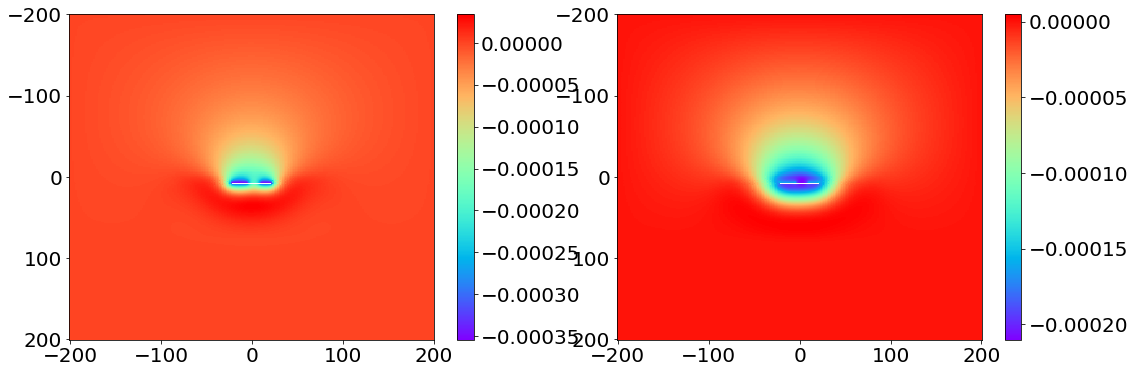

In [16]:
fig = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
h = ax.pcolormesh(Y/1e3,Z/1e3, u_pred_.real, cmap='rainbow',shading='auto')
# line_z = np.linspace(y.min()/1e3, y.max()/1e3, 2)[:,None]
# for ii in range(1,len(BCz)-1):
#     ax.plot(line_z, z[BCz[ii]]*np.ones((2,1))/1e3, 'w--', linewidth = 2)
# line_y = np.linspace(z.min()/1e3, z.max()/1e3, 2)[:,None]
# for ii in range(1,len(BCy)-1):
#     ax.plot(y[BCy[ii]]*np.ones((2,1))/1e3, line_y, 'w--', linewidth = 2)
ax.invert_yaxis()
fig.colorbar(h)

ax = plt.subplot(1,2,2)
h = ax.pcolormesh(Y/1e3,Z/1e3, u_pred_.imag, cmap='rainbow',shading='auto')
# for ii in range(1,len(BCz)-1):
#     ax.plot(line_z, z[BCz[ii]]*np.ones((2,1))/1e3, 'w--', linewidth = 2)
# for ii in range(1,len(BCy)-1):
#     ax.plot(y[BCy[ii]]*np.ones((2,1))/1e3, line_y, 'w--',linewidth = 2)
ax.invert_yaxis()
fig.colorbar(h)
# plt.savefig("./imag/TE_secondary.png")
plt.subplots_adjust(wspace=0.3)
plt.show()

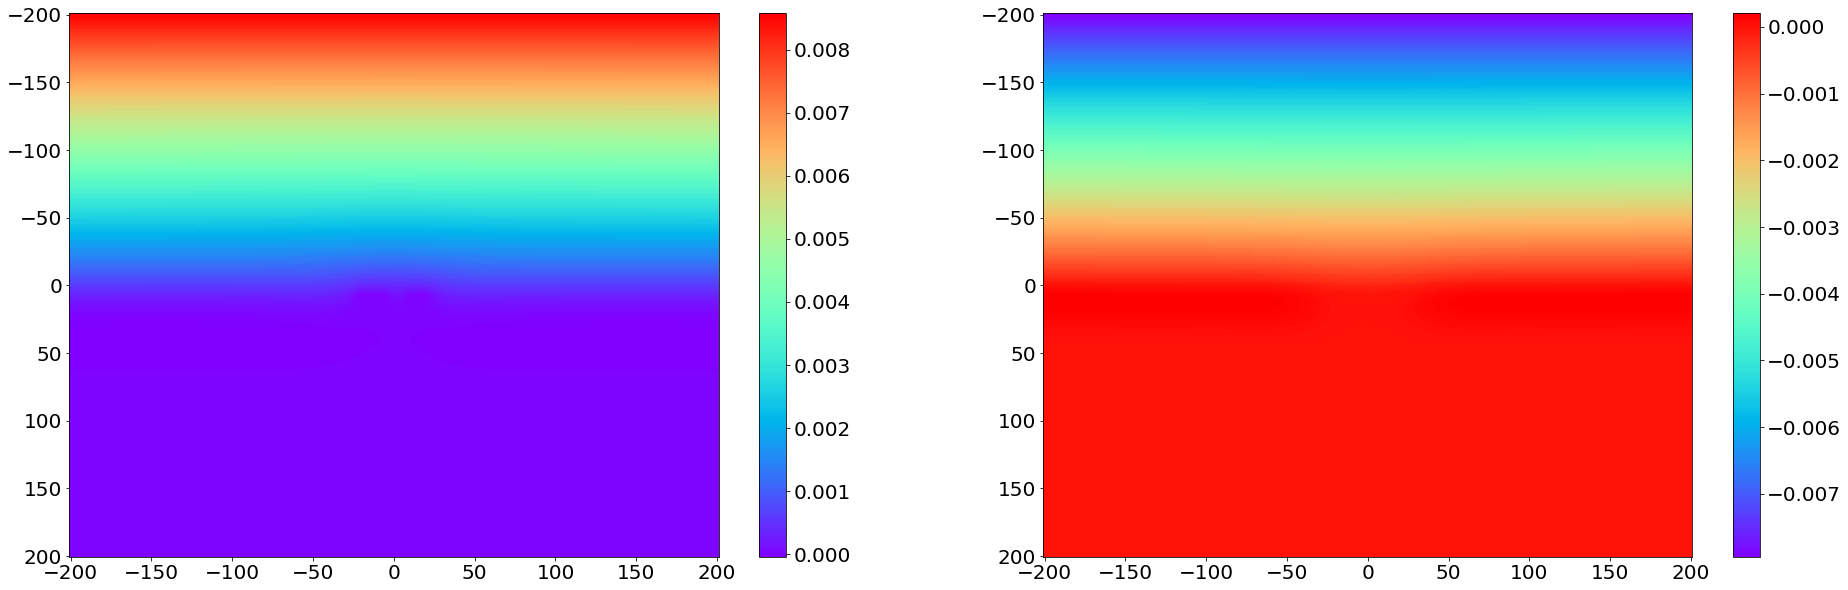

In [17]:
fig = plt.figure(figsize=(32,10))
ax = plt.subplot(1,2,1)
h = ax.pcolormesh(Y/1e3,Z/1e3, u_pred.real, cmap='rainbow',shading='auto')
line_z = np.linspace(y.min()/1e3, y.max()/1e3, 2)[:,None]
# for ii in range(1,len(BCz)-1):
#     ax.plot(line_z, z[BCz[ii]]*np.ones((2,1))/1e3, 'w--', linewidth = 2)
# line_y = np.linspace(z.min()/1e3, z.max()/1e3, 2)[:,None]
# for ii in range(1,len(BCy)-1):
#     ax.plot(y[BCy[ii]]*np.ones((2,1))/1e3, line_y, 'w--', linewidth = 2)
ax.invert_yaxis()
fig.colorbar(h)

ax = plt.subplot(1,2,2)
h = ax.pcolormesh(Y/1e3,Z/1e3, u_pred.imag, cmap='rainbow',shading='auto')
# for ii in range(1,len(BCz)-1):
#     ax.plot(line_z, z[BCz[ii]]*np.ones((2,1))/1e3, 'w--', linewidth = 2)
# for ii in range(1,len(BCy)-1):
#     ax.plot(y[BCy[ii]]*np.ones((2,1))/1e3, line_y, 'w--',linewidth = 2)
ax.invert_yaxis()
fig.colorbar(h)
# plt.savefig("./imag/full_uniform_sample.png")
plt.show()

In [18]:
II = complex(0,1)
Y_obs = np.linspace(-5e4,5e4,101)
iz = 2
id_b = 3 # idx of model where obssevation begin(from 1) 
id_e = 3# idx of model where obssevation end 

idx0 = np.where(Y_obs>y[BCy[id_b]])[0][0]
Y_0 = Y_obs[0:idx0]
Z_air = np.zeros(len(Y_0)) # 空气-地面分界面
u_2, u_x_2 = pinn2.predict_H(Y_0,Z_air, iz,id_b-1)
for ii in range(id_b+1,len(BCy)-id_e):
    idx = np.where(Y_obs>y[BCy[ii]])[0][0]
    Y_0 = Y_obs[idx0:idx]
    Z_air = np.zeros(len(Y_0))
    u_2_0, u_x_2_0 = pinn2.predict_H(Y_0,Z_air, iz,ii-1)# interface point
#     id0 = np.where(Y_obs==y[BCy[ii-1]])[0]
#     if id0.size !=0:
# #         id0 = id0[0][0]
#         u_temp,u_x_temp = pinn.predict_H(Y_0[0],Z_air[0],0,ii-2)
#         u_pred0[0] = (u_pred0[0]+ u_temp)/2.0
#         u_x0[0]    = (u_x0[0] + u_x_temp)/2.0

    u_2 = np.concatenate((u_2,u_2_0),0)
    u_x_2    = np.concatenate((u_x_2,u_x_2_0),0)
    idx0 = np.copy(idx)


ii = len(BCy)-id_e
Y_0 = Y_obs[idx:]
Z_air = np.zeros(len(Y_0))#空气-地面分界面

u_2_0, u_x_2_0 = pinn2.predict_H(Y_0,Z_air, iz,ii-1)


u_2 = np.concatenate((u_2,u_2_0),0)
u_x_2    = np.concatenate((u_x_2,u_x_2_0),0)
E0, H0 = E0_model.compute_E_H(np.concatenate((Y_obs.flatten()[:,None],(np.zeros(len(Y_obs))).flatten()[:,None]),1))
u      = E0[:,0:1]
u_x    = H0[:,1:2]*(II*omega*mu_0)

Ex   = u + u_2
Ex_z = u_x + u_x_2
Hy = Ex_z/(II*omega*mu_0)
Zxy = Ex/Hy

rho_a = np.abs(Zxy)**2/(omega*mu_0)

phs_a = np.arctan2(Zxy.imag,Zxy.real)* 180.0 / np.pi*(-1.0)


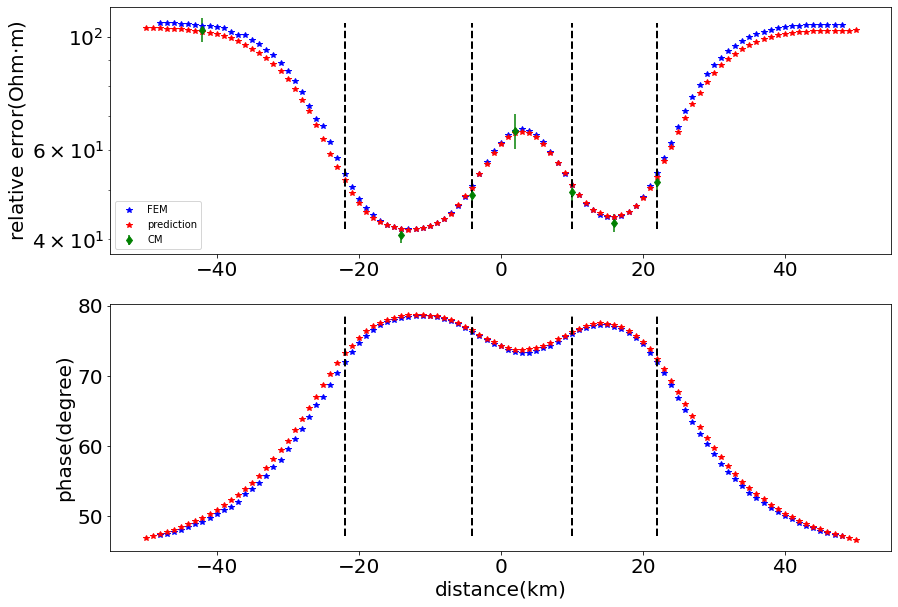

In [26]:
fig = plt.figure(figsize=(14,10))
ax = plt.subplot(2,1,1)
ax.plot(obs_FEM, rho_FEM_TE,'b*',label="FEM")
ax.plot(Y_obs/1e3, rho_a,'r*',label="prediction")
# ax.plot(obs_c,rho_c,'g')

# ax.plot(obs, rho_E,'gD', markersize=8,label="COMMEMI")
line = np.linspace(rho_FEM_TE.min(), rho_FEM_TE.max(), 2)[:,None]
for ii in range(3,len(BCy)-3):
    ax.plot(y[BCy[ii]]*np.ones((2,1))/1e3, line, 'k--', linewidth = 2)
ax.errorbar(obs_c, rho_TE,yerr=rho_TE_er,color='green',marker='d',linestyle='',label="CM")
ax.set_yscale("log")
ax.set_ylabel(r'relative error(Ohm$\cdot$m)')
ax.legend()

ax = plt.subplot(2,1,2)
ax.plot(obs_FEM, phs_FEM_TE,'b*',label="FEM")
ax.plot(Y_obs/1e3, phs_a,'r*',label="prediction")
line = np.linspace(phs_FEM_TE.min(), phs_FEM_TE.max(), 2)[:,None]
for ii in range(3,len(BCy)-3):
    ax.plot(y[BCy[ii]]*np.ones((2,1))/1e3, line, 'k--', linewidth = 2)
ax.set_ylabel('phase(degree)')
ax.set_xlabel('distance(km)')

# plt.savefig("./imag/CM2D2_no_COMMEMI.jpg", dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()